# ❇️LSTM #

##  ` 👉Opis zadania` ### 


## 🇵🇱 Zadanie 2.2.8** (opcjonalnie)

Nowy zbiór z `KLEJ` - [PolEmo2.0-IN](https://clarin-pl.eu/dspace/handle/11321/710). To zestaw recenzji online z dziedziny medycyny i hoteli. Zadaniem jest przewidzenie sentymentu recenzji.

* input: `../input/klej/klej_polemo2.0-in/train.tsv`
* models: `../models/word2vec/klej_polemo2.0-in_train`

##  ` 👉Import bibliotek` ### 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import random
import os

from gensim.utils import simple_preprocess
import tensorflow.keras.preprocessing.text as kpt 

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten
from keras.layers import Dropout

from itertools import product
import mlflow
import time
import datetime
import warnings

import team_helper as th
from team_helper import recall, precision, f1, get_y
from team_helper import random_polemo2_opinion as random_opinion

##  ` 👉Usunięcie niepotrzebnych ostrzeżeń + ustawienie mlflow` ### 

In [3]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [4]:
mlflow.set_tracking_uri("file:///home/jovyan/nlp2/shared-mlruns/team-three/mariusz")

##  ` 👉Próba zapewnienia powtarzalności eksperymentu` ### 

In [5]:
seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

##  ` 👉Eksploracja zbioru` ### 

In [6]:
df = pd.read_csv('../input/klej/klej_polemo2.0-in/train.tsv', sep='\t')

In [7]:
df

,sentence,target
0,Super lekarz i człowiek przez duże C . Bardzo ...,__label__meta_plus_m
1,Bardzo olewcze podejscie do pacjenta . Przypro...,__label__meta_minus_m
2,Lekarz zalecił mi kurację alternatywną do doty...,__label__meta_amb
3,Konsumenci oczywiście kierują się ceną . Te l...,__label__meta_zero
4,Pani Doktor Iwona jest profesjonalistką w każd...,__label__meta_plus_m
...,...,...
5739,"Centralne skrzydło jest jednokondygnacyjne , z...",__label__meta_zero
5740,Ogólnie w hotelu panuje balagan informacyjny -...,__label__meta_minus_m
5741,Przybyli śmy z rodziną na krotki wypoczynek . ...,__label__meta_amb
5742,Opinię może wyrazić dzisiaj każdy i jest to je...,__label__meta_zero


In [8]:
df['target'].value_counts(normalize=True)

__label__meta_minus_m    0.380223
__label__meta_plus_m     0.270369
__label__meta_amb        0.181929
__label__meta_zero       0.167479
Name: target, dtype: float64

##  ` 👉Wyodrębnienie zmiennych i preprocessing` ### 

In [9]:
X_oryg = df['sentence'].map(th.simple_tokens)
Xprep = df['sentence'].map(th.preprocessing).map(simple_preprocess)

y = get_y(df, 'target')

##  ` 👉Wybór parametrów do eksperymentu` ### 

In [10]:
EXP_NAME = 'LSTM_polemo2_0_IN_X_oryg'
SELECTED_X = X_oryg

# jak duży ma być słownik
num_words_list = [500, 300] 

# do ilu słów mamy uciąć daną recenzję
maxlens_list = [60, 50, 40, 10]

# ile ma być dwukierunkowych warstw w LSTM
nobs_list = [0, 1 , 2] 

# jak długi wektor ma reprezentować dane słowo
embedding_vector_lengths_list = [400, 500] 

# liczba jednostek
units_list = [32, 64]

# liczba epok
epochs_list = [10]

##  ` 👉Przydatne funkcje` ### 

In [11]:
def make_sequence(inputX, num_words, maxlen):
    tokenizer = kpt.Tokenizer(num_words)
    tokenizer.fit_on_texts(inputX) 
    sequences = tokenizer.texts_to_sequences(inputX) 
    X = sequence.pad_sequences(sequences, maxlen, padding='post', truncating='post')
    return X

In [12]:
def get_multi_LSTM(nob, unit, num_words, embedding_vector_length, maxlen):
    if nob == 0:
        model = Sequential([
            Embedding(num_words, embedding_vector_length, input_length=maxlen),
            Dropout(0.9),
            LSTM(unit),
            Dense(y.shape[1], activation='softmax')
        ])
    if nob == 1:
        model = Sequential([
            Embedding(num_words, embedding_vector_length, input_length=maxlen),
            Dropout(0.9),
            Bidirectional(LSTM(unit, dropout=0.5)),
            #Bidirectional(LSTM(unit)),
            #Dropout(0.5),
            Dense(y.shape[1], activation='softmax')
        ])
    if nob == 2:
        model = Sequential([
            Embedding(num_words, embedding_vector_length, input_length=maxlen),
            Dropout(0.9),
            Bidirectional(LSTM(unit, dropout=0.5, return_sequences=True)),
            Bidirectional(LSTM(unit, dropout=0.5)),
            #Bidirectional(LSTM(unit, return_sequences=True)),
            #Bidirectional(LSTM(unit)),
            #Dropout(0.5),
            Dense(y.shape[1], activation='softmax')
        ])
    return model

##  ` 👉Eksperyment` ### 

1/96
Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, units=32, epochs=10, nobs=0)
train_f1_curr =  0.702
train_f1_max =  0.702
val_f1_curr =  0.666
val_f1_max =  0.666
time:  167.99
----------
2/96
Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, units=64, epochs=10, nobs=0)
train_f1_curr =  0.713
train_f1_max =  0.717
val_f1_curr =  0.669
val_f1_max =  0.687
time:  221.95
----------
3/96
Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=500, units=32, epochs=10, nobs=0)
train_f1_curr =  0.713
train_f1_max =  0.713
val_f1_curr =  0.67
val_f1_max =  0.67
time:  194.63
----------
4/96
Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=500, units=64, epochs=10, nobs=0)
train_f1_curr =  0.717
train_f1_max =  0.717
val_f1_curr =  0.671
val_f1_max =  0.671
time:  253.88
----------
5/96
Embedding (max_top_words=500, max_opinion_length=60, embedding_vector_lengths=400, un

37/96
Embedding (max_top_words=500, max_opinion_length=10, embedding_vector_lengths=400, units=32, epochs=10, nobs=0)
train_f1_curr =  0.577
train_f1_max =  0.577
val_f1_curr =  0.453
val_f1_max =  0.453
time:  44.56
----------
38/96
Embedding (max_top_words=500, max_opinion_length=10, embedding_vector_lengths=400, units=64, epochs=10, nobs=0)
train_f1_curr =  0.583
train_f1_max =  0.583
val_f1_curr =  0.446
val_f1_max =  0.457
time:  54.2
----------
39/96
Embedding (max_top_words=500, max_opinion_length=10, embedding_vector_lengths=500, units=32, epochs=10, nobs=0)
train_f1_curr =  0.588
train_f1_max =  0.588
val_f1_curr =  0.433
val_f1_max =  0.455
time:  47.93
----------
40/96
Embedding (max_top_words=500, max_opinion_length=10, embedding_vector_lengths=500, units=64, epochs=10, nobs=0)
train_f1_curr =  0.594
train_f1_max =  0.594
val_f1_curr =  0.453
val_f1_max =  0.468
time:  58.4
----------
41/96
Embedding (max_top_words=500, max_opinion_length=10, embedding_vector_lengths=400, u

73/96
Embedding (max_top_words=300, max_opinion_length=40, embedding_vector_lengths=400, units=32, epochs=10, nobs=0)
train_f1_curr =  0.681
train_f1_max =  0.681
val_f1_curr =  0.678
val_f1_max =  0.678
time:  131.84
----------
74/96
Embedding (max_top_words=300, max_opinion_length=40, embedding_vector_lengths=400, units=64, epochs=10, nobs=0)
train_f1_curr =  0.672
train_f1_max =  0.682
val_f1_curr =  0.671
val_f1_max =  0.681
time:  165.02
----------
75/96
Embedding (max_top_words=300, max_opinion_length=40, embedding_vector_lengths=500, units=32, epochs=10, nobs=0)
train_f1_curr =  0.687
train_f1_max =  0.687
val_f1_curr =  0.676
val_f1_max =  0.676
time:  146.59
----------
76/96
Embedding (max_top_words=300, max_opinion_length=40, embedding_vector_lengths=500, units=64, epochs=10, nobs=0)
train_f1_curr =  0.694
train_f1_max =  0.694
val_f1_curr =  0.682
val_f1_max =  0.682
time:  189.22
----------
77/96
Embedding (max_top_words=300, max_opinion_length=40, embedding_vector_lengths=

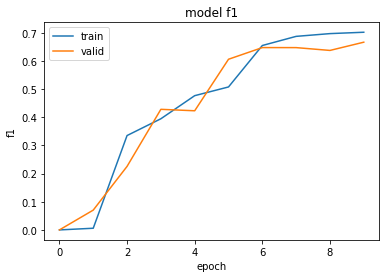

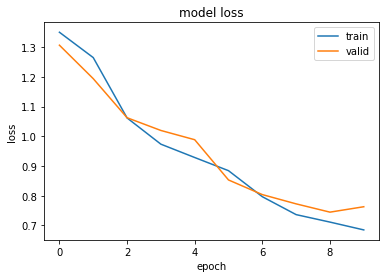

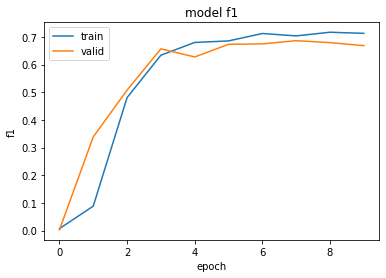

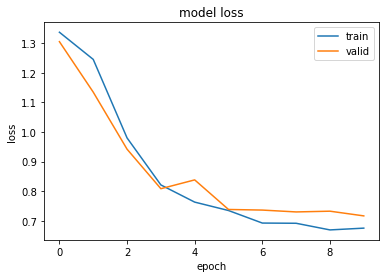

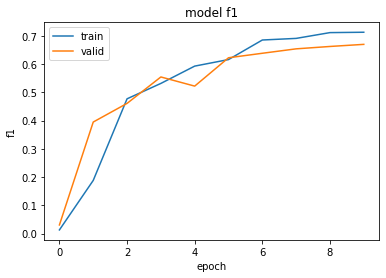

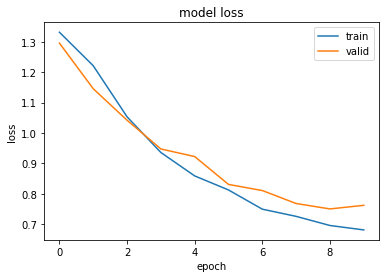

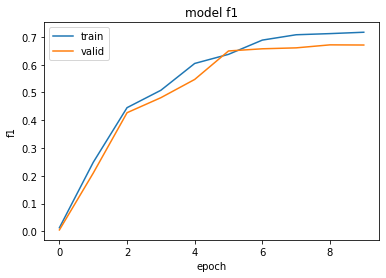

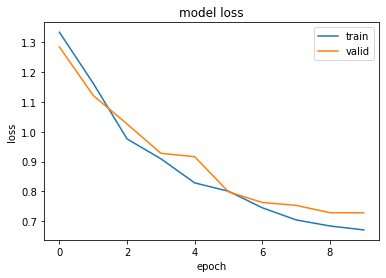

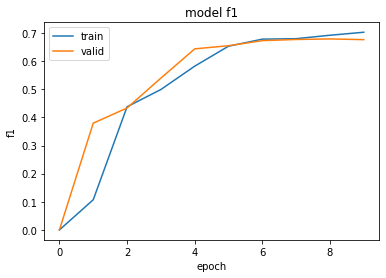

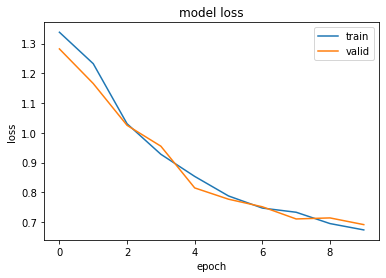

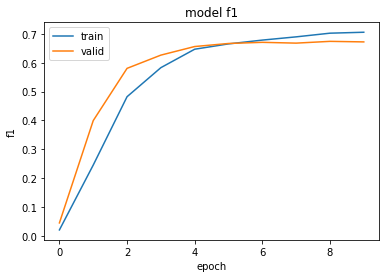

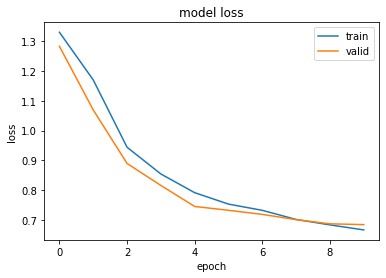

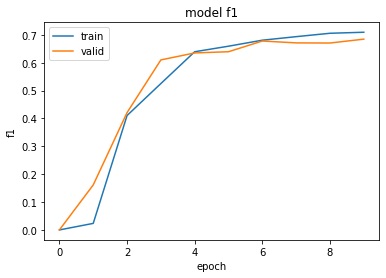

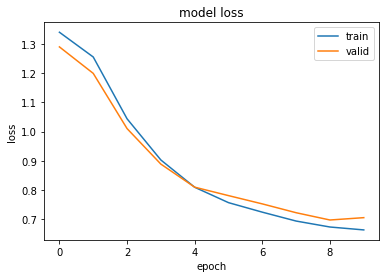

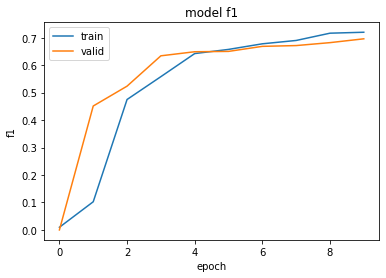

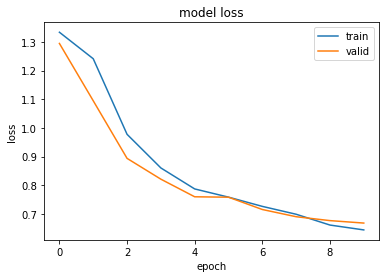

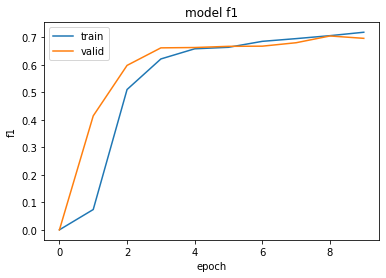

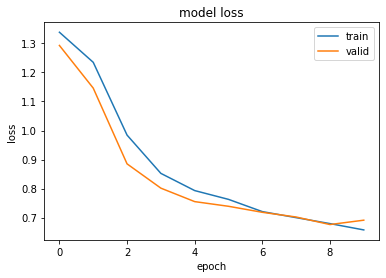

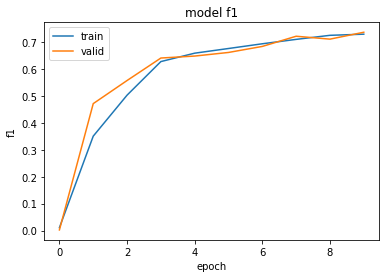

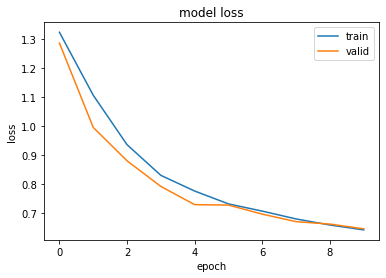

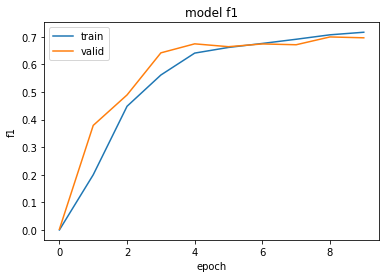

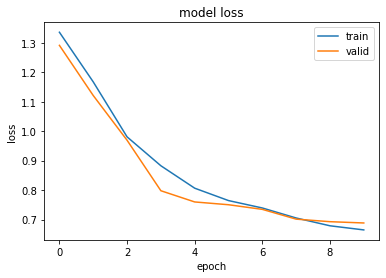

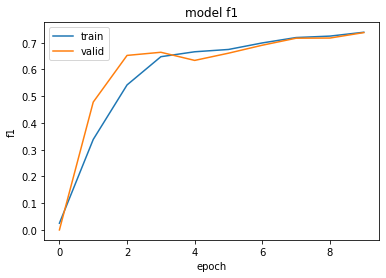

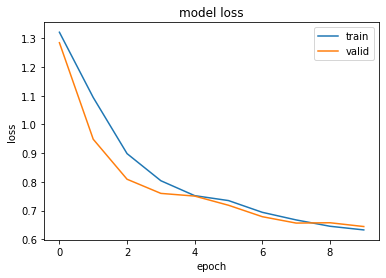

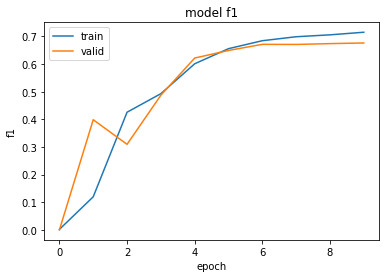

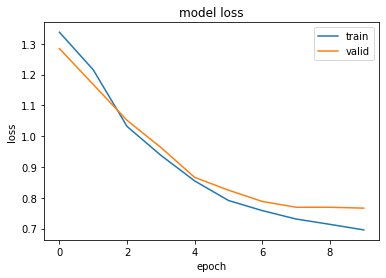

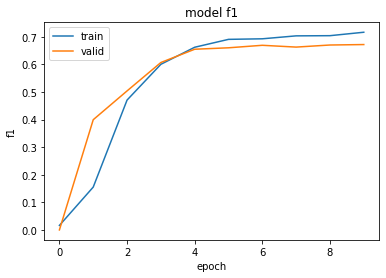

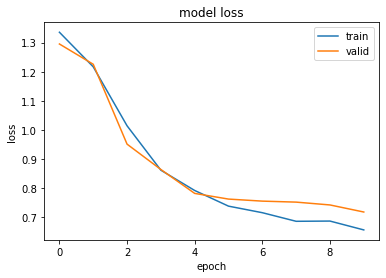

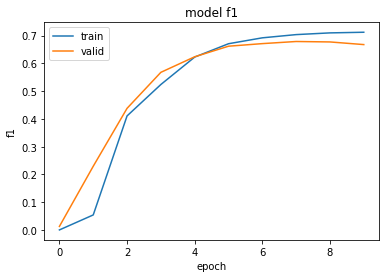

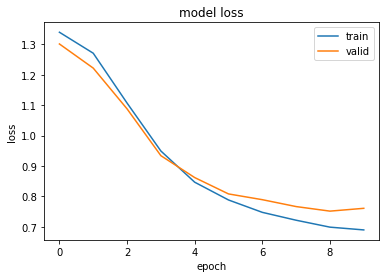

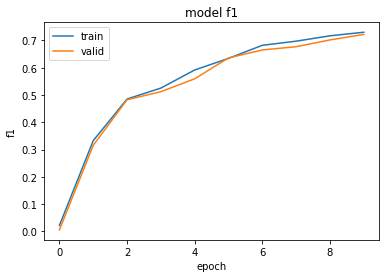

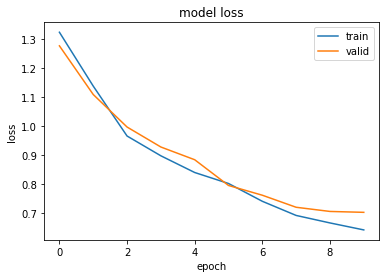

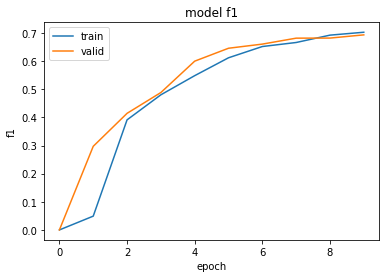

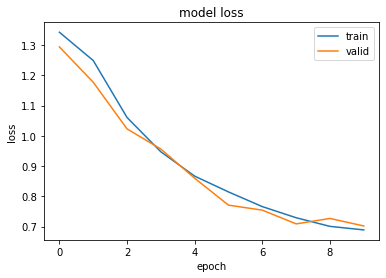

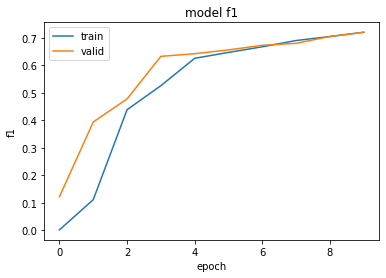

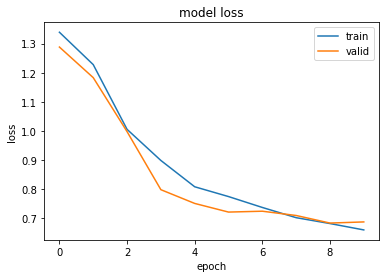

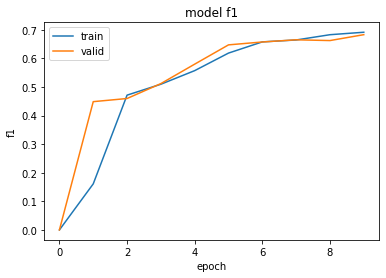

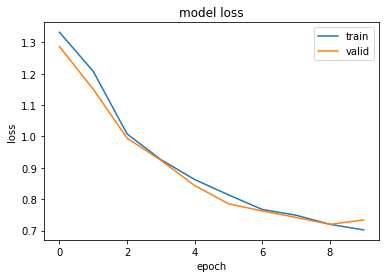

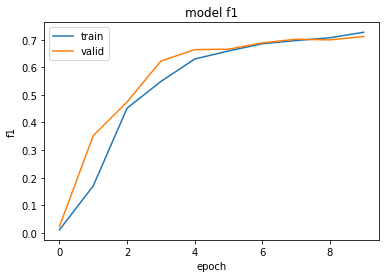

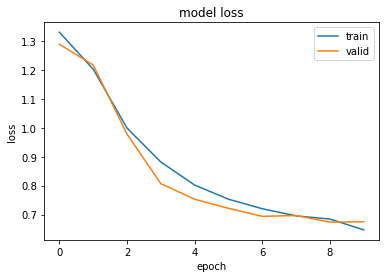

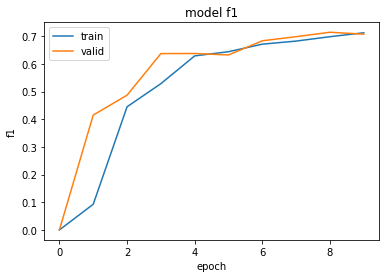

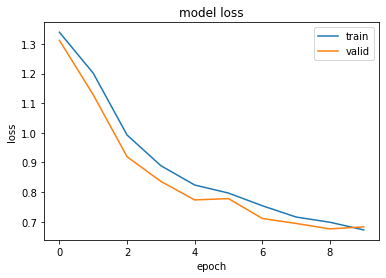

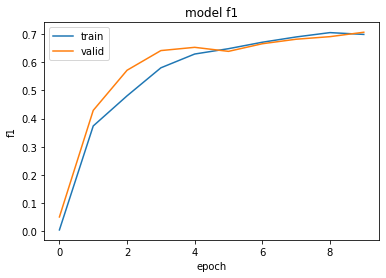

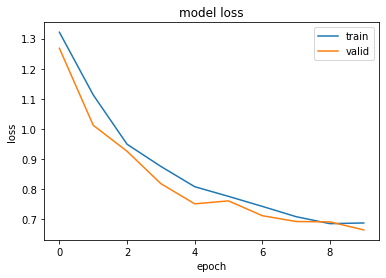

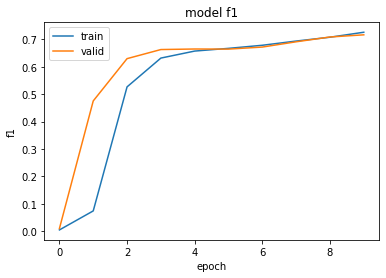

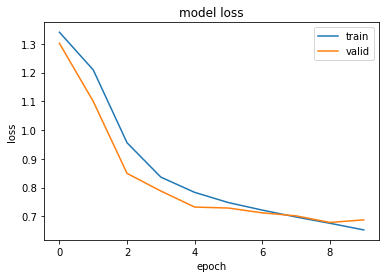

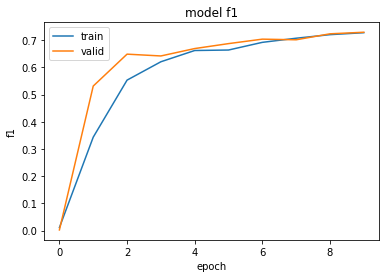

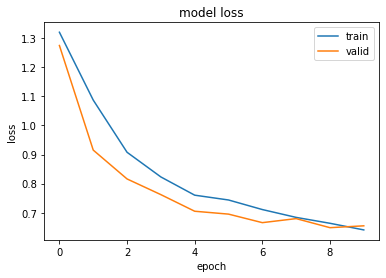

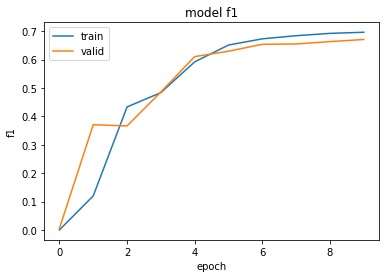

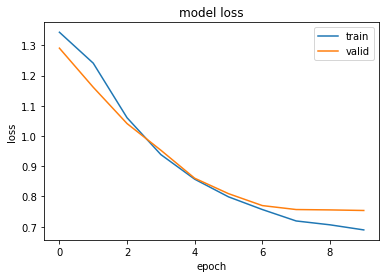

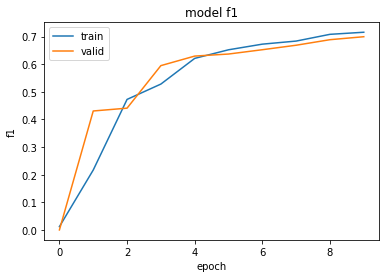

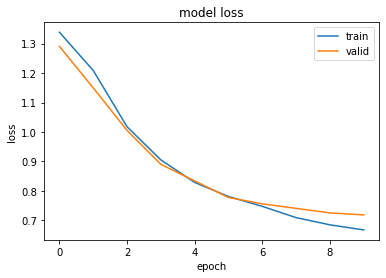

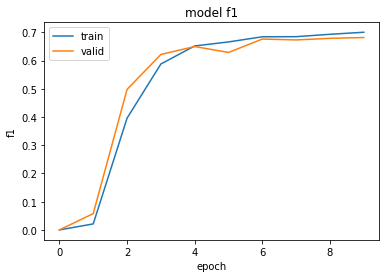

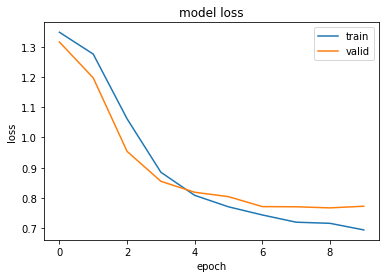

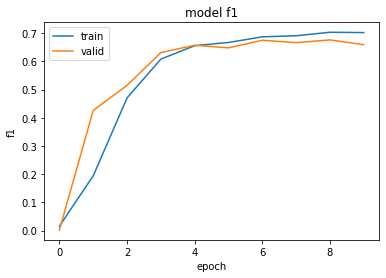

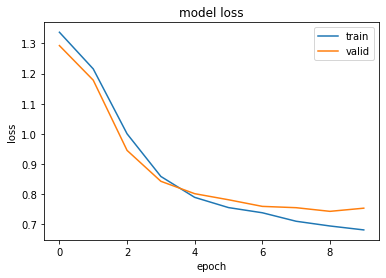

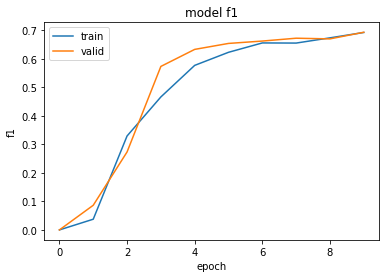

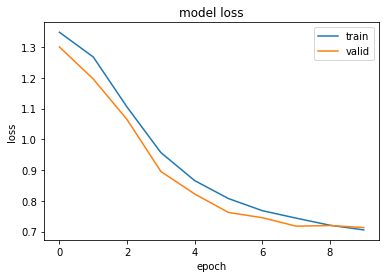

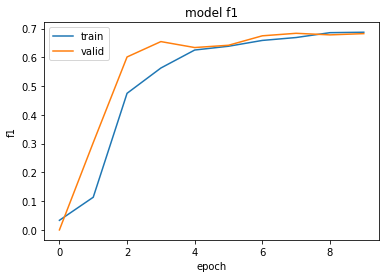

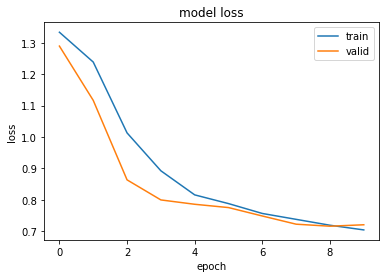

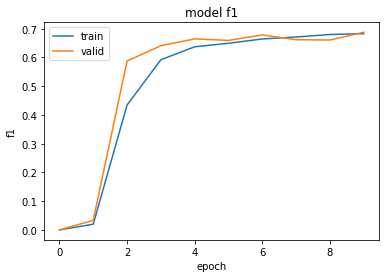

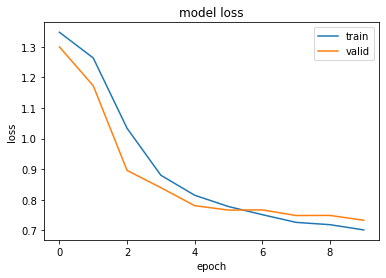

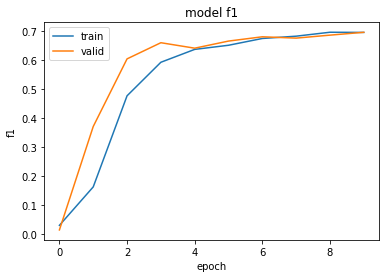

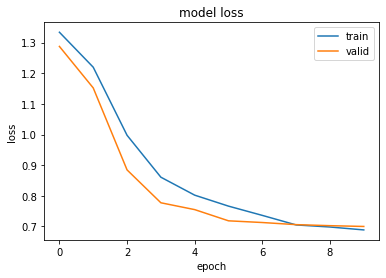

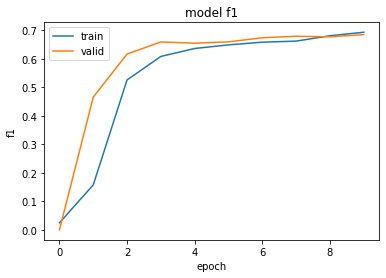

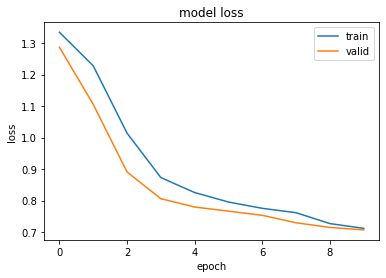

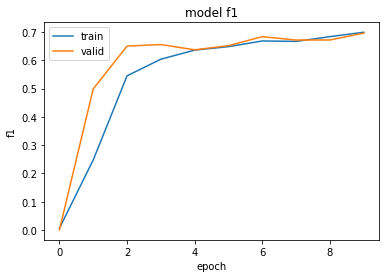

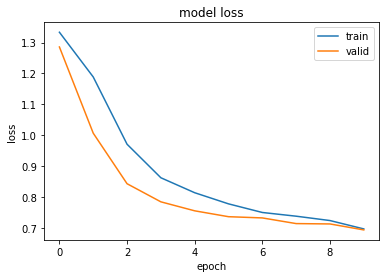

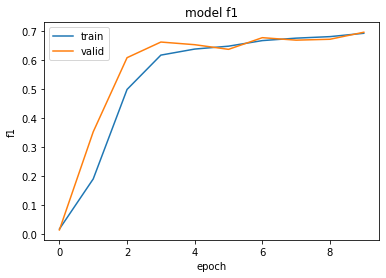

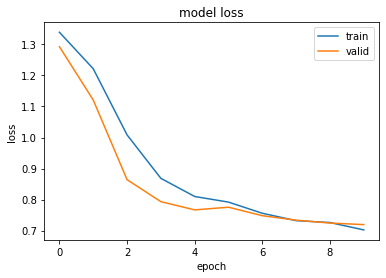

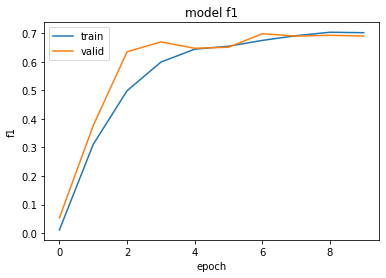

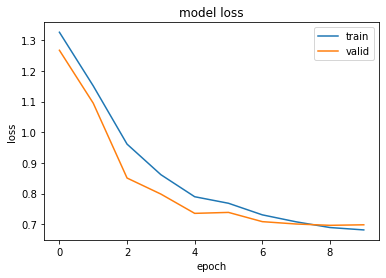

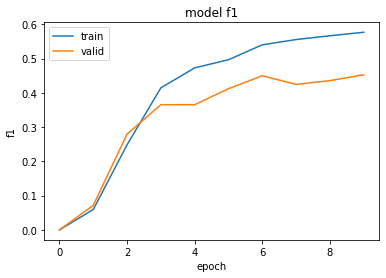

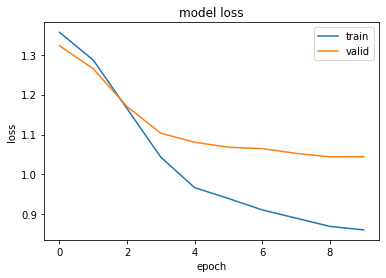

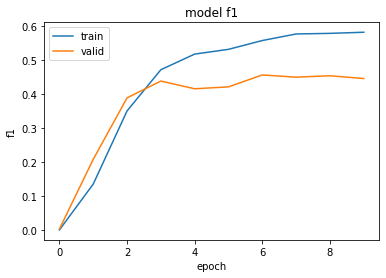

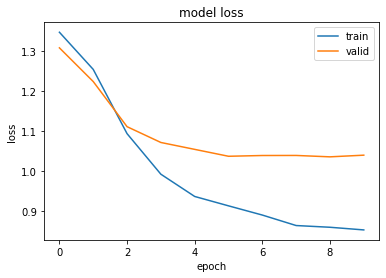

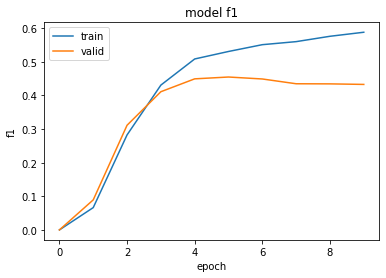

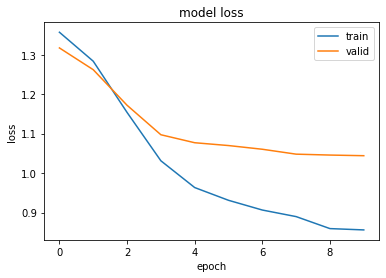

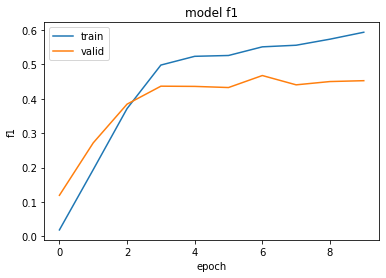

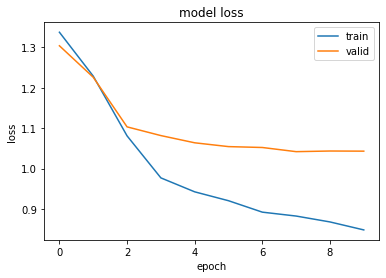

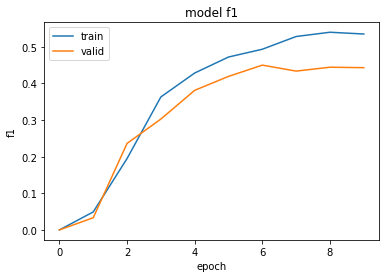

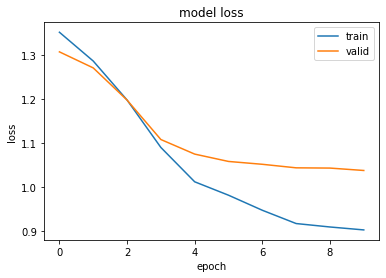

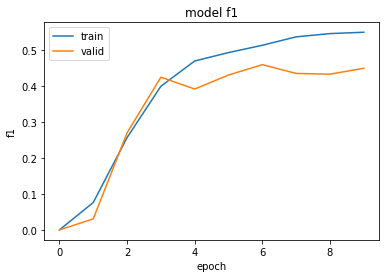

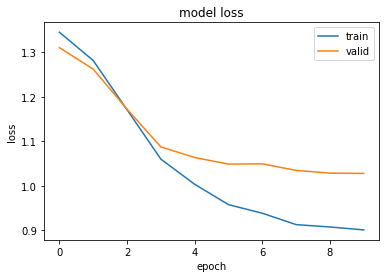

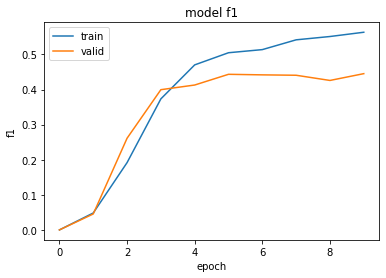

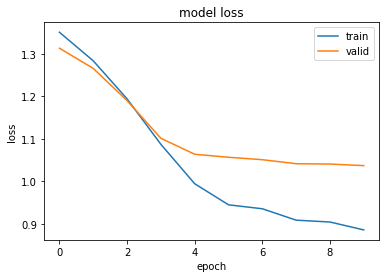

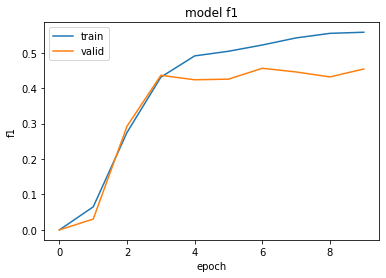

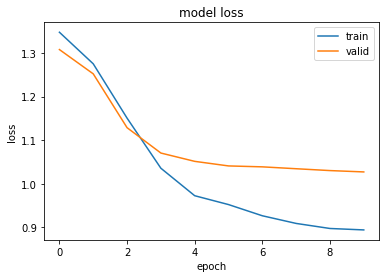

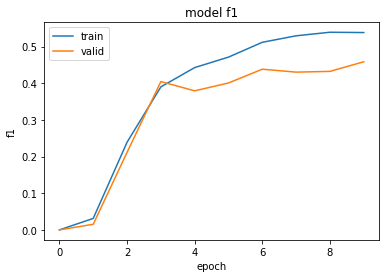

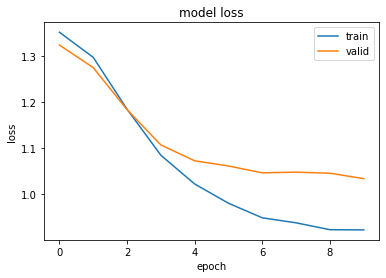

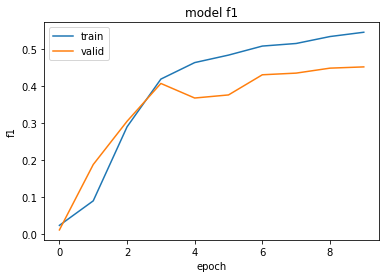

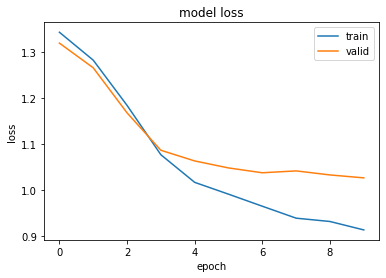

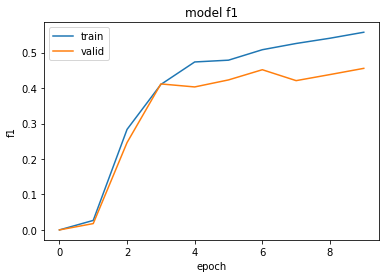

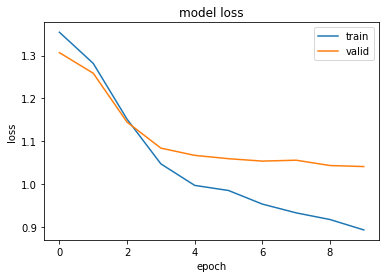

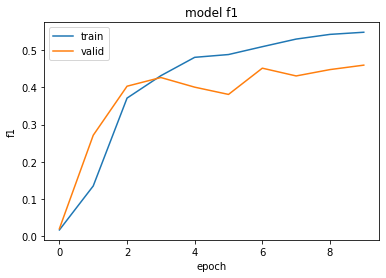

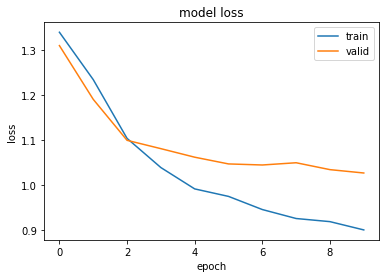

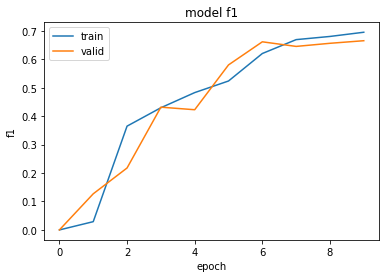

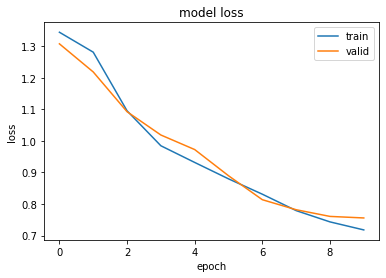

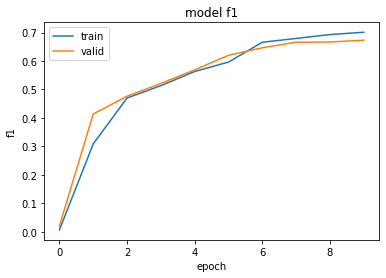

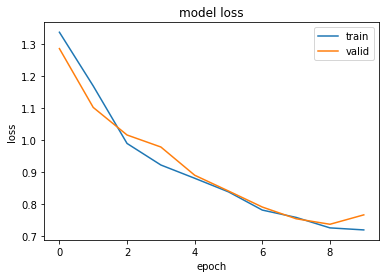

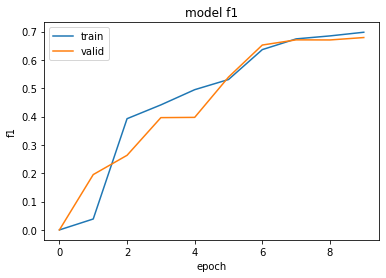

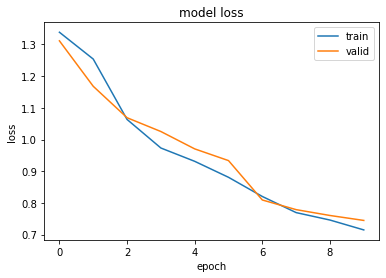

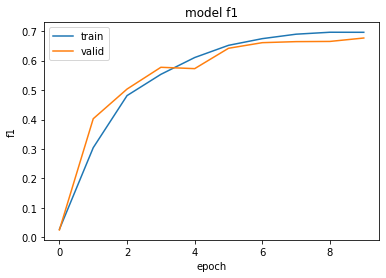

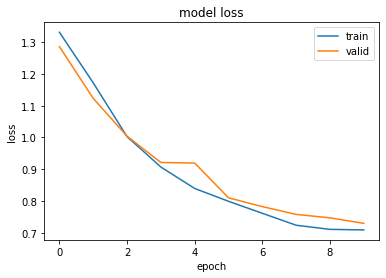

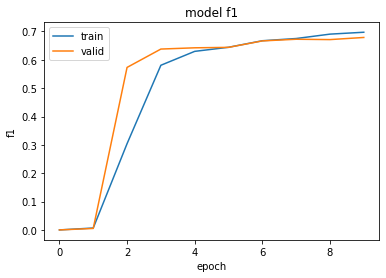

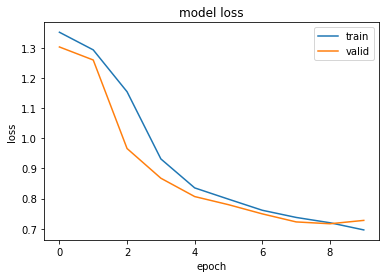

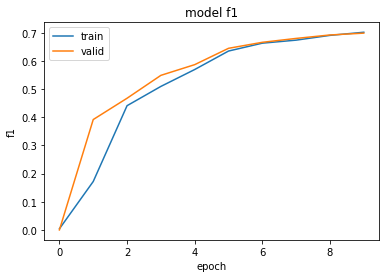

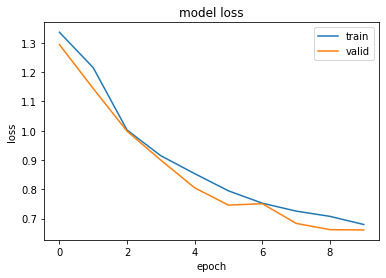

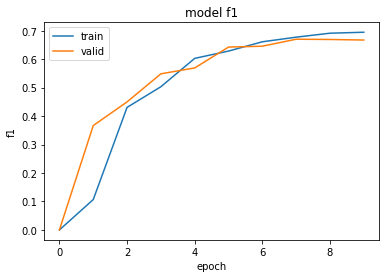

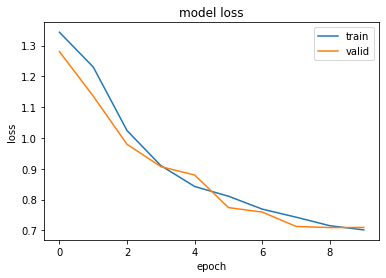

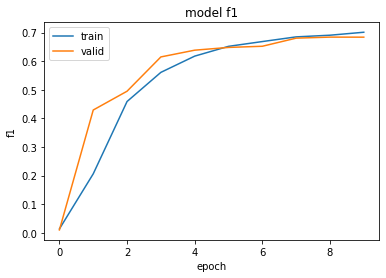

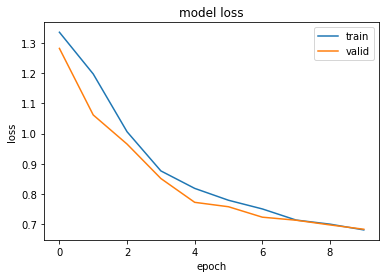

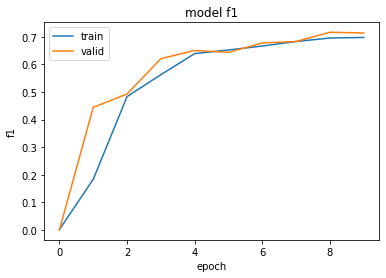

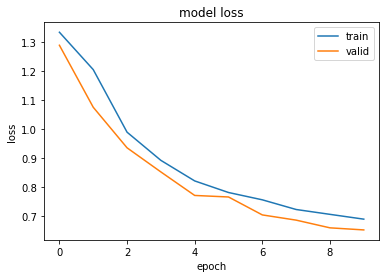

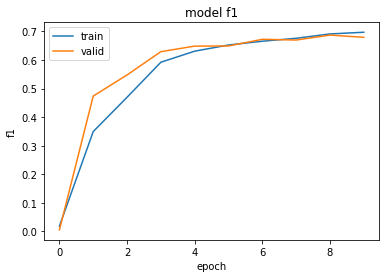

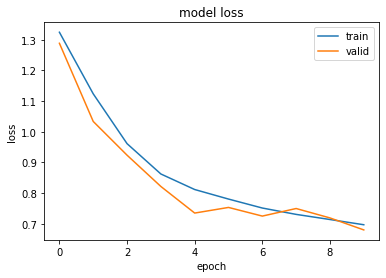

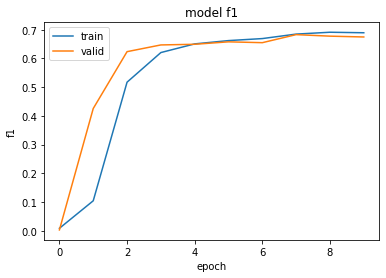

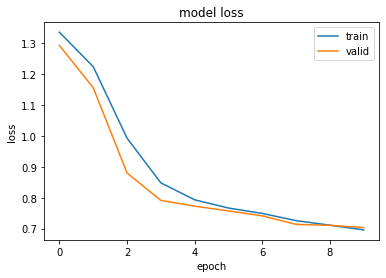

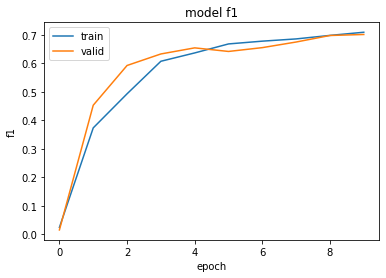

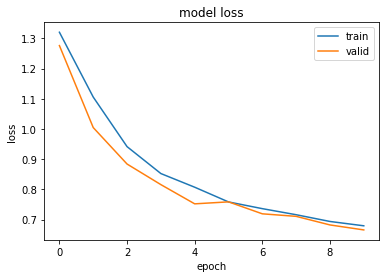

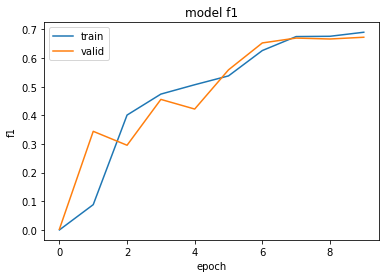

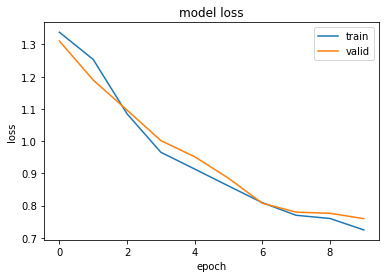

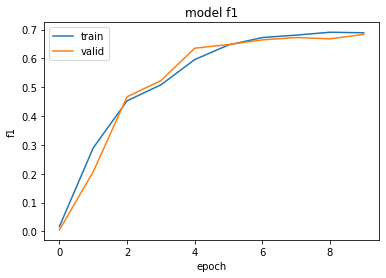

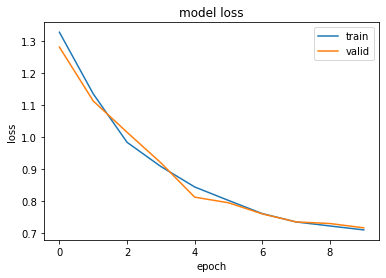

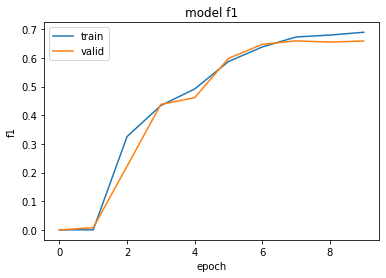

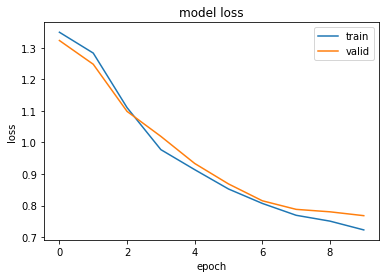

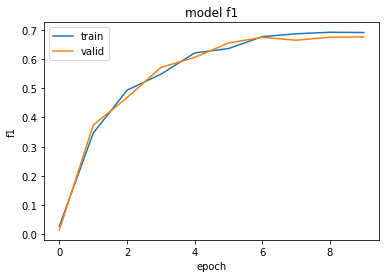

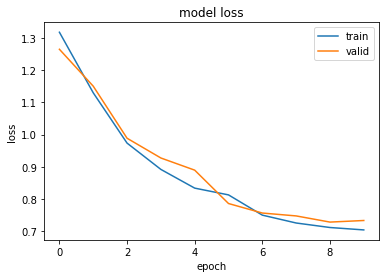

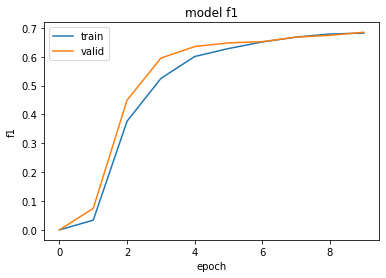

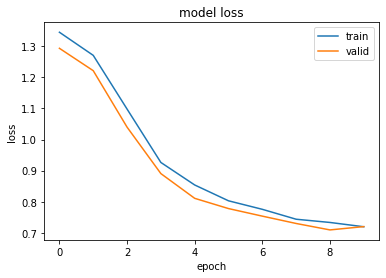

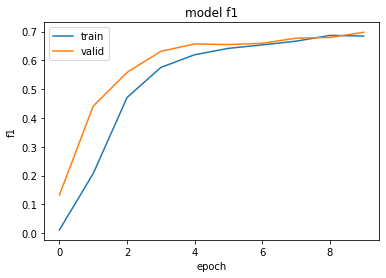

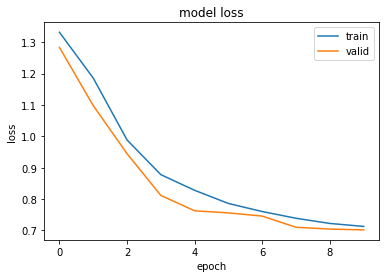

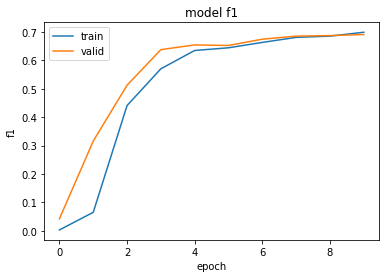

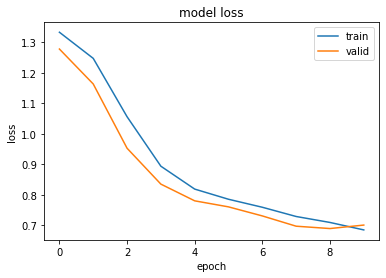

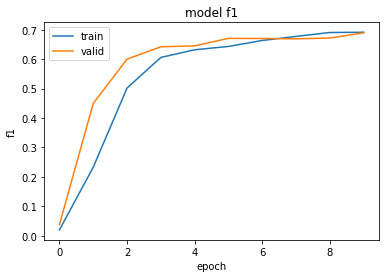

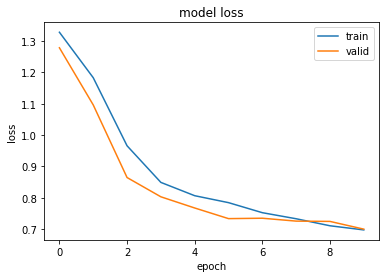

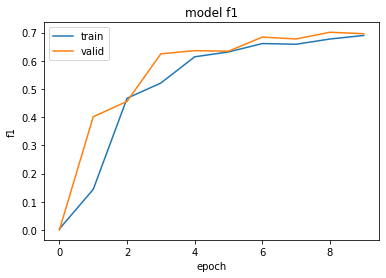

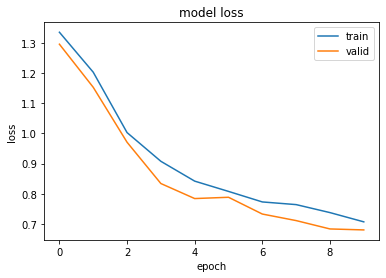

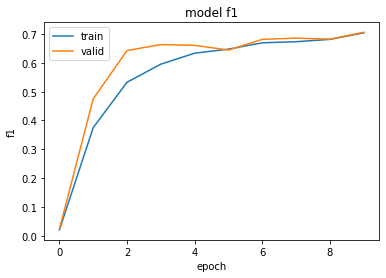

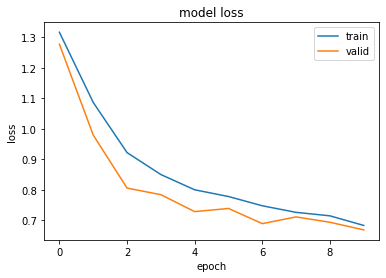

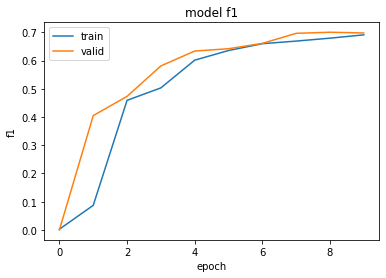

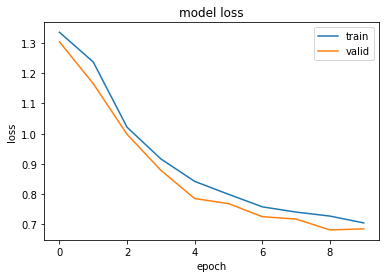

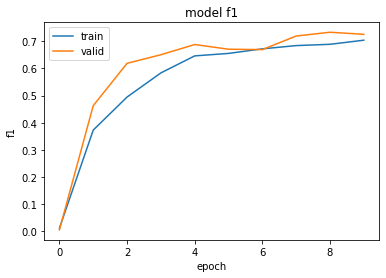

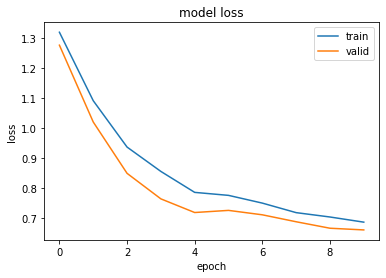

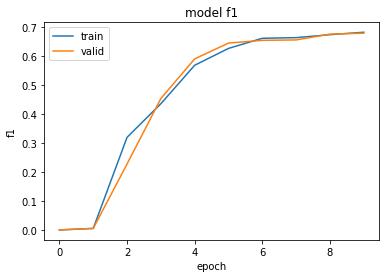

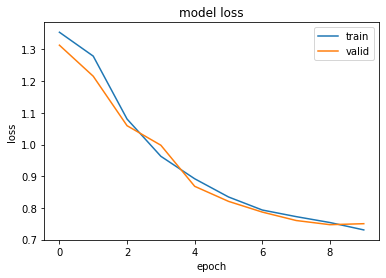

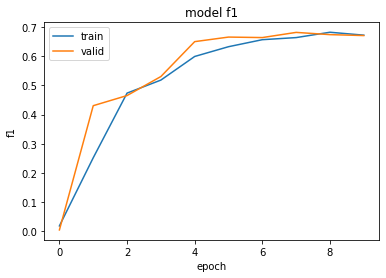

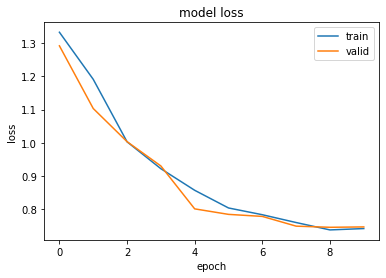

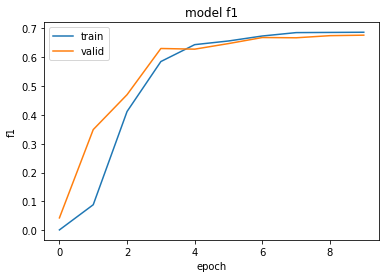

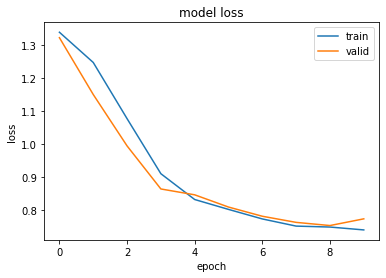

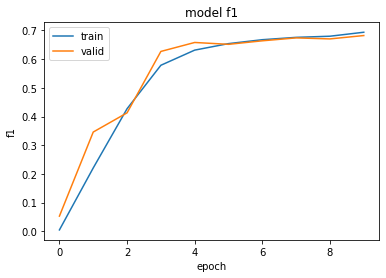

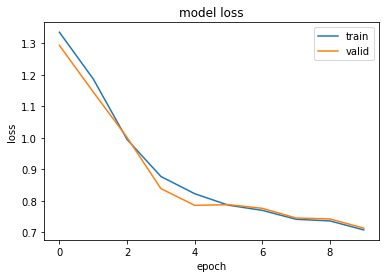

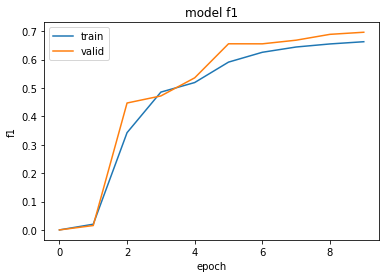

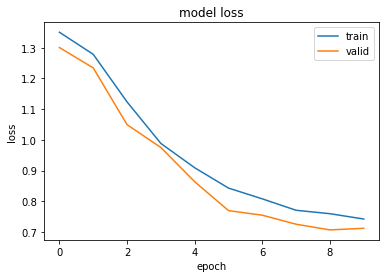

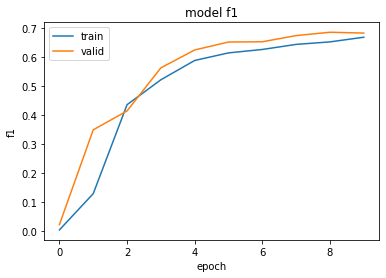

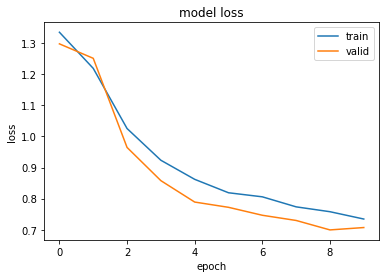

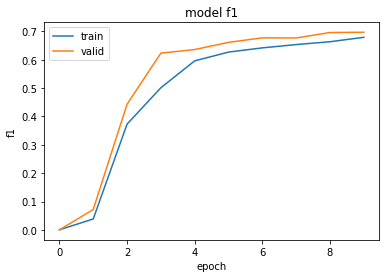

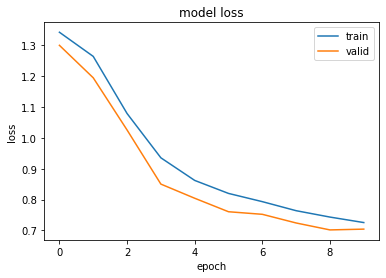

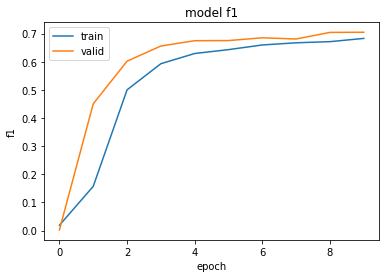

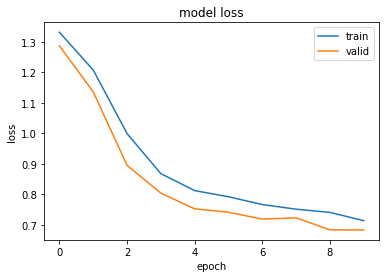

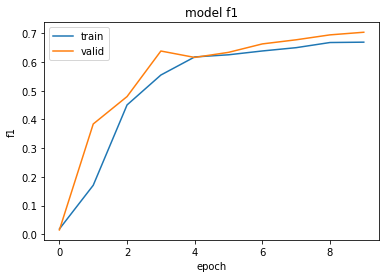

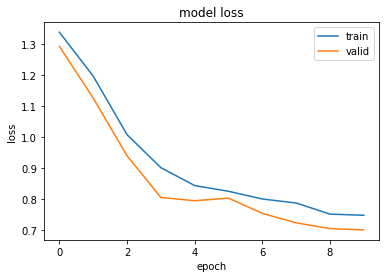

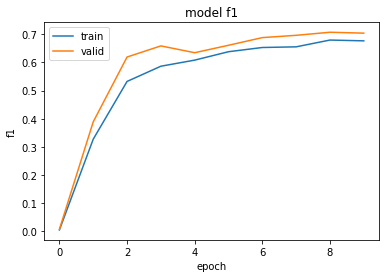

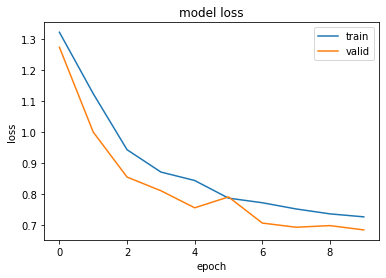

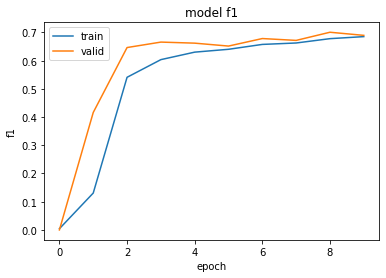

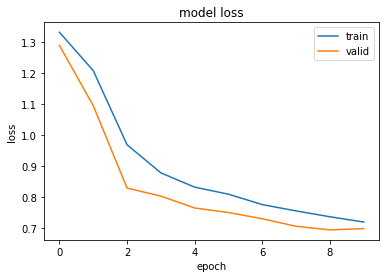

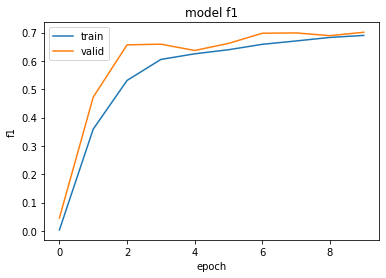

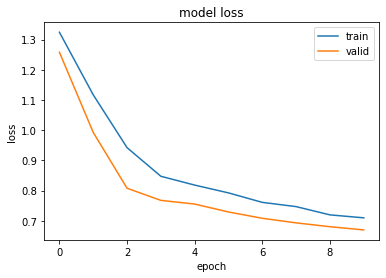

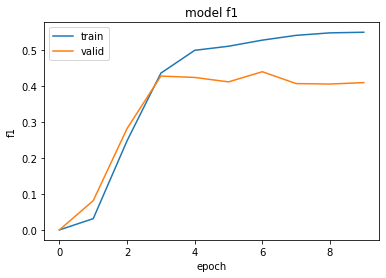

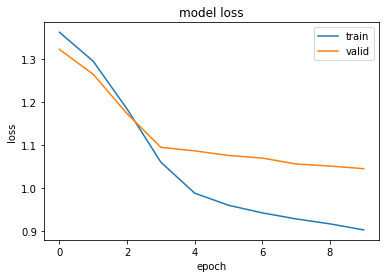

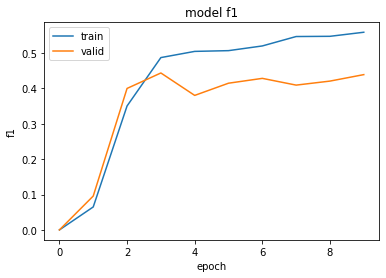

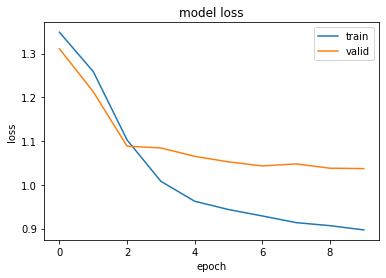

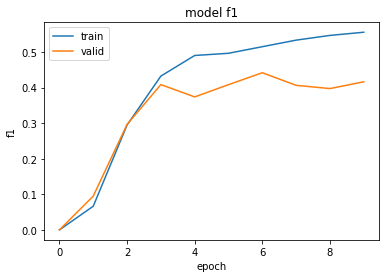

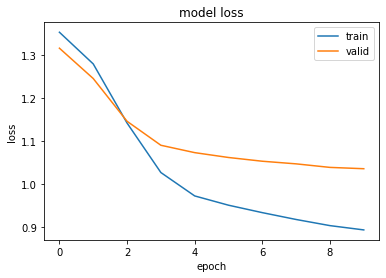

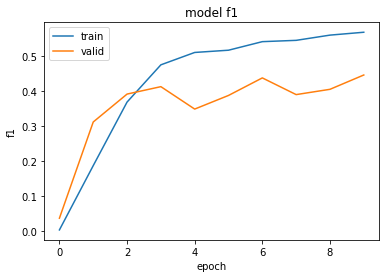

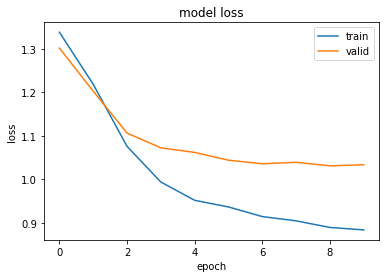

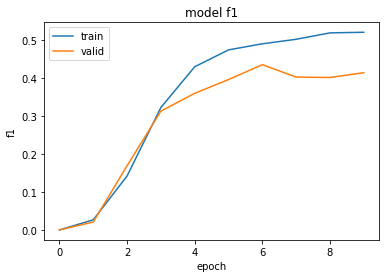

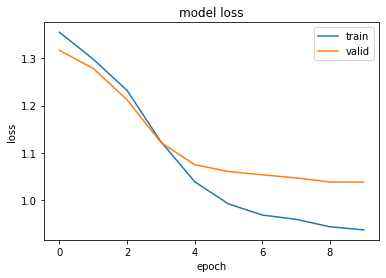

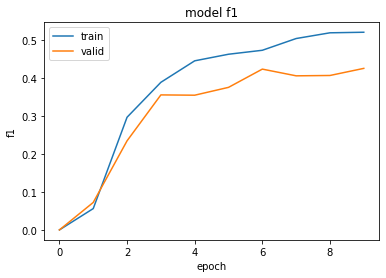

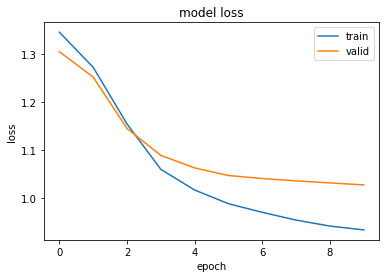

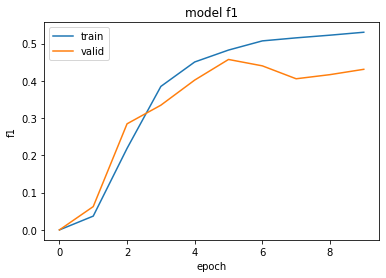

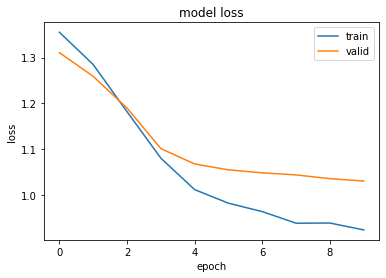

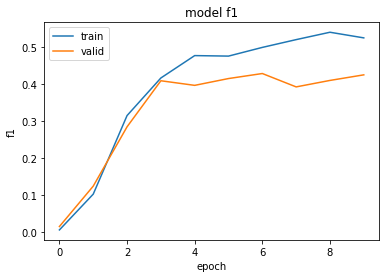

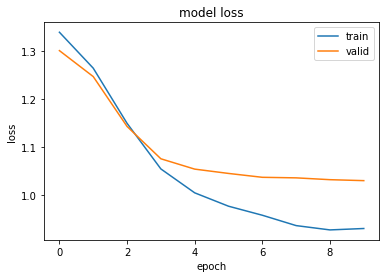

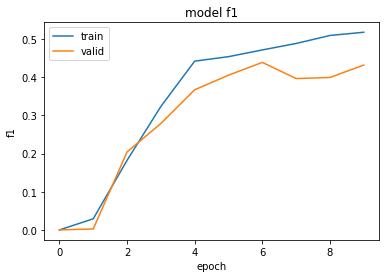

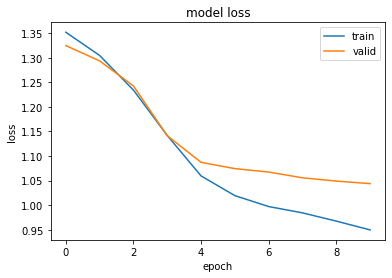

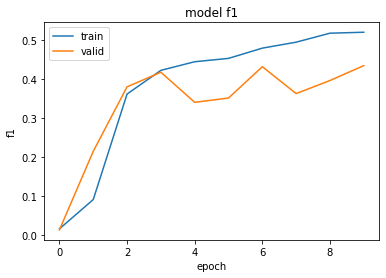

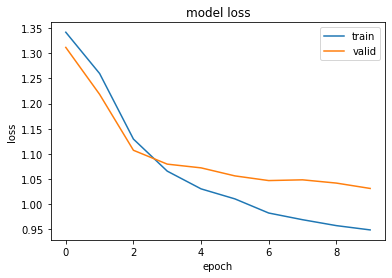

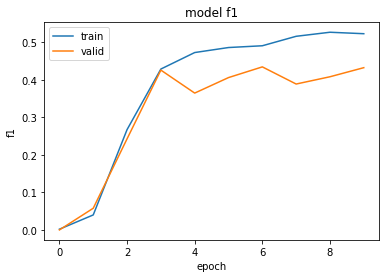

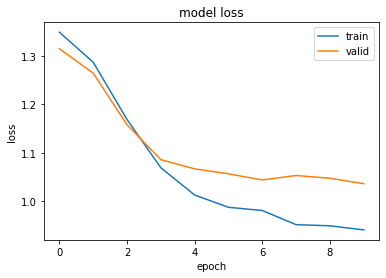

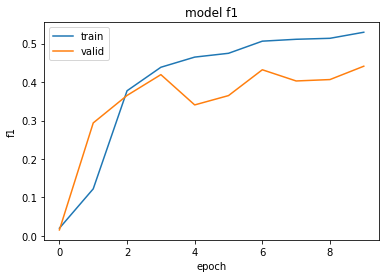

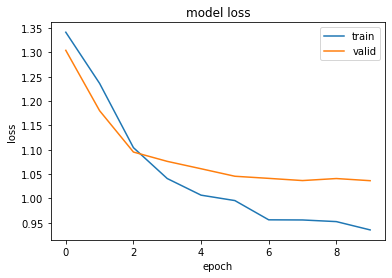

In [13]:
params_cnt = len(num_words_list)*\
len(maxlens_list)*\
len(nobs_list)*\
len(embedding_vector_lengths_list)*\
len(units_list)*len(epochs_list)

exp_start = datetime.datetime.now()

for n,(num_words, maxlen, nob, embedding_vector_length, unit, epoch) in \
enumerate(product(num_words_list, maxlens_list, nobs_list, embedding_vector_lengths_list, units_list, epochs_list),1):
    
    X = make_sequence(SELECTED_X, num_words, maxlen)

    model_str = f'Embedding (max_top_words={num_words}, max_opinion_length={maxlen}, ' \
    + f'embedding_vector_lengths={embedding_vector_length}, units={unit}, epochs={epoch}, nobs={nob})'

    print(f'{n}/{params_cnt}')
    print(model_str)

    with mlflow.start_run(experiment_id=th._eid(EXP_NAME), run_name=model_str):

        model = get_multi_LSTM(nob, unit, num_words, embedding_vector_length, maxlen)

        start = time.time()
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
        history = model.fit( 
            X, y,
            epochs=epoch, batch_size=256,
            validation_split=0.1,
            #callbacks=[PlotLossesKeras()],
            verbose=0)
        end = time.time()
        
        print('train_f1_curr = ', round(history.history['f1'][-1],3))
        print('train_f1_max = ', round(max(history.history['f1']),3))
        print('val_f1_curr = ', round(history.history['val_f1'][-1],3))
        print('val_f1_max = ',round(max(history.history['val_f1']),3))
        
        print('time: ',round((end-start),2))
        print('-'*10)

        # log params
        mlflow.log_param('model', model_str)
        mlflow.log_param('max_opinion_length', maxlen)
        mlflow.log_param('max_top_words', num_words)
        mlflow.log_param('epoch', epoch)
        mlflow.log_param('unit', unit)
        mlflow.log_param('nob', nob)
        
        # log metrics
        mlflow.log_metric('train_accuracy_curr', history.history['accuracy'][-1])
        mlflow.log_metric('train_accuracy_max', max(history.history['accuracy']))
        mlflow.log_metric('val_accuracy_curr', history.history['val_accuracy'][-1])
        mlflow.log_metric('val_accuracy_max', max(history.history['val_accuracy']))
        
        mlflow.log_metric('train_precision_curr', history.history['accuracy'][-1])
        mlflow.log_metric('train_precision_max', max(history.history['precision']))
        mlflow.log_metric('val_precision_curr', history.history['val_precision'][-1])
        mlflow.log_metric('val_precision_max', max(history.history['val_precision']))

        mlflow.log_metric('train_recall_curr', history.history['recall'][-1])
        mlflow.log_metric('train_recall_max', max(history.history['recall']))
        mlflow.log_metric('val_recall_curr', history.history['val_recall'][-1])
        mlflow.log_metric('val_recall_max', max(history.history['val_recall']))
        
        mlflow.log_metric('train_f1_curr', history.history['f1'][-1])
        mlflow.log_metric('train_f1_max', max(history.history['f1']))
        mlflow.log_metric('val_f1_curr', history.history['val_f1'][-1])
        mlflow.log_metric('val_f1_max', max(history.history['val_f1']))
        
        mlflow.log_metric('loss', history.history['loss'][-1])
        mlflow.log_metric('calc_time', (end-start))
        

        # log artifacts
        fig = plt.figure()
        plt.plot(history.history['f1'])
        plt.plot(history.history['val_f1'])
        plt.title('model f1')
        plt.ylabel('f1')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='best')
        mlflow.log_figure(fig, "f1-plot.png")
        
        fig2 = plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='best')
        mlflow.log_figure(fig2, "loss-plot.png")
        
        
exp_end = datetime.datetime.now()
print('='*10)
print(f'Start of experiment: {exp_start}')
print(f'End of experiment: {exp_end}')
th.calculate_delta((exp_end-exp_start))

dfruns = mlflow.search_runs(experiment_ids=[th._eid(EXP_NAME)])

In [14]:
dfruns.to_csv('LSTM_X_oryg.csv')

In [14]:
!mlflow ui --backend-store-uri /home/jovyan/nlp2/shared-mlruns/team-three/mariusz --default-artifact-root /home/jovyan/nlp2/shared-mlruns/team-three/mariusz --port 5001

[2021-10-09 19:13:45 +0000] [3604] [INFO] Starting gunicorn 20.1.0
[2021-10-09 19:13:45 +0000] [3604] [INFO] Listening at: http://127.0.0.1:5001 (3604)
[2021-10-09 19:13:45 +0000] [3604] [INFO] Using worker: sync
[2021-10-09 19:13:45 +0000] [3606] [INFO] Booting worker with pid: 3606
^C
[2021-10-09 19:25:59 +0000] [3604] [INFO] Handling signal: int
[2021-10-09 19:25:59 +0000] [3606] [INFO] Worker exiting (pid: 3606)


In [42]:
!mlflow ui

[2021-10-05 17:25:19 +0000] [677] [INFO] Starting gunicorn 20.1.0
[2021-10-05 17:25:19 +0000] [677] [INFO] Listening at: http://127.0.0.1:5000 (677)
[2021-10-05 17:25:19 +0000] [677] [INFO] Using worker: sync
[2021-10-05 17:25:19 +0000] [679] [INFO] Booting worker with pid: 679
^C
[2021-10-05 17:26:37 +0000] [677] [INFO] Handling signal: int
[2021-10-05 17:26:37 +0000] [679] [INFO] Worker exiting (pid: 679)
